## Robustness and fairness

Prof. Changho Suh, TA Jaewoong Cho, Gyeongjo Hwang

1.     A setting where one can see a performance degradation due to poisoned data when applying non-robust algorithms (like logistic regression);

2.     Another setting where one can see a fairness issue;

3.     Learning-to-reweight algorithm for robustness;

4.     Jafar’s algorithm for fairness.




## 2. Fair machine learning

실습목표

-- Fairness metric 측정하는 코드 구현

---diparate impact? disparate mistreatment? Jafar 논문 2개에 걸쳐 제안된 metric들

-- Fair dataset과 Unfair dataset을 인위적으로 생성한다.

-- 각각의 dataset에 logistic regression을 적용한 뒤 성능 및 Fairness를 측정

-- Jafar's fair learning 알고리즘을 구현한다. https://arxiv.org/pdf/1507.05259.pdf

--- Lambda가 주어지면 Loss + Lambda * Fairness-regularization-term을 GD로 푸는 알고리즘 구현

-- Unfair dataset에 Jafar 알고리즘 기반 logistic regression을 적용한 뒤 성능을 측정, lambda값에 따라 나온 (fairness & acc) tradeoff를 그린다

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from Robust_utils import generate_normal, plot, decision_boundary, draw_boundary, Normalize, Logistic, sigmoid, initialize_with_zeros
from fairness_utils import generate_unfair_data, plot_unfair_data

In [2]:
(X_train, Y_train, z_train), (X_test, Y_test, z_test) = generate_unfair_data(n_samples=5000)

In [3]:
print(X_train.shape, Y_train.shape, z_train.shape)
print(X_test.shape, Y_test.shape, z_test.shape)

(2, 4000) (4000,) (4000,)
(2, 1000) (1000,) (1000,)


In [4]:
X_train = Normalize(X_train)
X_test = Normalize(X_test)

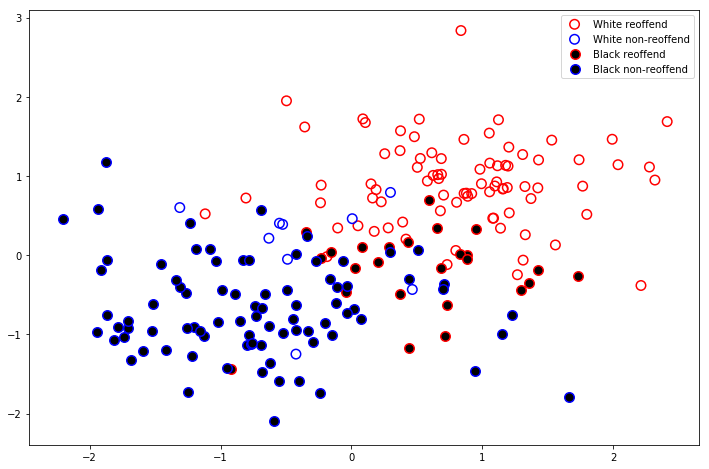

In [5]:
plt.figure(figsize=(12,8))
plot_unfair_data(X_train.T, Y_train, z_train)

In [6]:
d = Logistic(X_train, Y_train, X_test, Y_test, print_cost=True)
print(d["test_acc"])

Cost after iteration [100/2000]: 0.191130
Cost after iteration [200/2000]: 0.185646
Cost after iteration [300/2000]: 0.184654
Cost after iteration [400/2000]: 0.184408
Cost after iteration [500/2000]: 0.184339
Cost after iteration [600/2000]: 0.184319
Cost after iteration [700/2000]: 0.184313
Cost after iteration [800/2000]: 0.184311
Cost after iteration [900/2000]: 0.184310
Cost after iteration [1000/2000]: 0.184310
Cost after iteration [1100/2000]: 0.184310
Cost after iteration [1200/2000]: 0.184310
Cost after iteration [1300/2000]: 0.184310
Cost after iteration [1400/2000]: 0.184310
Cost after iteration [1500/2000]: 0.184310
Cost after iteration [1600/2000]: 0.184310
Cost after iteration [1700/2000]: 0.184310
Cost after iteration [1800/2000]: 0.184310
Cost after iteration [1900/2000]: 0.184310
Cost after iteration [2000/2000]: 0.184310

train accuracy: 92.575 %
test accuracy: 93.5 %
93.5


In [7]:
def measure_disparate_impact(w, b, X, Y, z):
    Yhat, _ = forward_LR(w, b, X, Y)
    Ytilde = np.round(Yhat.reshape(-1))
    
    z_0_mask = (z == 0.0)
    z_1_mask = (z == 1.0)
    z_0_sum = np.sum(z_0_mask)
    z_1_sum = np.sum(z_1_mask)
    
    Ytilde_1_z_0 = (Ytilde == 1.0)[z_0_mask]
    Ytilde_1_z_1 = (Ytilde == 1.0)[z_1_mask]
    Ytilde_1_z_0_sum = np.sum(Ytilde_1_z_0)
    Ytilde_1_z_1_sum = np.sum(Ytilde_1_z_1)
    
    ratio1 = Ytilde_1_z_0_sum / z_1_sum
    ratio2 = Ytilde_1_z_1_sum / z_0_sum
    DI = min(ratio1, ratio2)
    return DI

In [10]:
print(measure_disparate_impact(d["w"], d["b"], X_test, Y_test, z_test))

0.17857142857142858


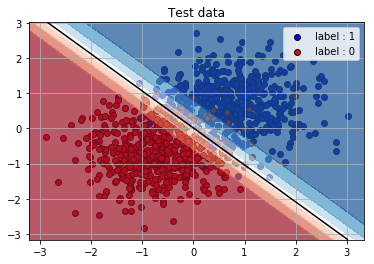

In [11]:
draw_boundary(d["w"], d["b"], X_test, Y_test, title='Test data', colormap=True)

In [12]:
def forward_fair(w, b, X, Y, z, lambda_):
    m = X.shape[1]
    Yhat = sigmoid(np.dot(w.T, X) + b)
    cross_entropy = (- 1 / m) * np.sum(Y * np.log(Yhat) + (1 - Y) * (np.log(1 - Yhat)))
    
    z_bar = np.mean(z)
    corr = (1 / m) * np.sum((z - z_bar) * (np.dot(w.T, X) + b))
    
    cost = cross_entropy + lambda_ * np.abs(corr)
    return Yhat, cost, corr

In [13]:
def backward_fair(w, b, X, Y, z, Yhat, corr, lambda_):
    m = X.shape[1]
    z_bar = np.mean(z)
    # print(m, z_bar)
    
    mask = 1.0 if corr > 0 else -1.0
    # tmp = (-1) * np.ones_like(mask)
    # tmp[mask] = 1.0
    # print("tmp: ", tmp)
    # print((lambda_ / m) * tmp * np.dot(X, (z - z_bar).reshape(-1, 1)))
    dw = (1 / m) * np.dot(X, (Yhat - Y).T) + (lambda_ / m) * mask * np.dot(X, (z - z_bar).reshape(-1, 1))
    # print("w: ", w)
    # print("dw: ", dw)
    db = (1 / m) * np.sum(Yhat - Y)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    
    grads = {"dw": dw, "db": db}
    return grads

In [14]:
def fit_fair(w, b, X, Y, z, num_iterations, lambda_, learning_rate, print_cost=False):
    costs = []
    
    for i in range(num_iterations):
        # Cost and gradient calculation
        Yhat, cost, corr = forward_fair(w, b, X, Y, z, lambda_)
        grads = backward_fair(w, b, X, Y, z, Yhat, corr, lambda_)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        w = w - learning_rate * dw  # need to broadcast
        b = b - learning_rate * db
        
        # Record the costs
        if i % 10 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and (i + 1) % 1 == 0 or (i + 1) == num_iterations:
            print ("Cost after iteration [%i/%i]: %f" % (i + 1, num_iterations, cost))#, end='\r')
    params = {"w": w, "b": b}
    
    return params, costs

In [15]:
def predict_fair(w, b, X):
    m = X.shape[1]
    assert(w.shape[0] == X.shape[0])
    
    Yhat = sigmoid(np.dot(w.T, X) + b)
    Yhat[Yhat > 0.5] = 1
    Yhat[Yhat <= 0.5] = 0
    Y_prediction = Yhat
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [18]:
def Logistic_fair(X, Y, z, X_test, Y_test, z_test, num_iterations, lambda_, learning_rate, print_cost=False):
    w, b = initialize_with_zeros(X_train.shape[0])
    
    parameters, costs = fit_fair(w, b, X, Y, z, num_iterations, lambda_, learning_rate, print_cost)
    
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_test = predict_fair(w, b, X_test)
    Y_prediction_train = predict_fair(w, b, X_train)
    
    train_acc = 100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100
    test_acc = 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100
    DI = measure_disparate_impact(w, b, X_test, Y_test, z_test)

    print("train accuracy: {} %".format(train_acc))
    print("test accuracy: {} %".format(test_acc))
    print("disparate impact: {:.3f}".format(DI))
    print()

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "train_acc": train_acc,
         "test_acc": test_acc,
         "DI": DI,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [33]:
acc_fairness = []
model_history = []
lambda_range = np.linspace(0, 1.05, 31)
# fig, axes = plt.subplots(11)
# plt.figure(figsize=(16,12))
for i, lambda_ in enumerate(lambda_range):
# for i, lambda_ in enumerate(lambda_range[1:2]):
    d = Logistic_fair(X_train, Y_train, z_train, X_test, Y_test, z_test, 3000, lambda_, learning_rate=1e-5, print_cost=False)
    print((lambda_, d["test_acc"], d["DI"]))
    print()
    
    # axes[i].plot(range(200), d["costs"])
    acc_fairness.append((lambda_, d["test_acc"], d["DI"]))
    model_history.append(d)
# plt.show()

Cost after iteration [3000/3000]: 0.685647
train accuracy: 92.45 %
test accuracy: 93.5 %
disparate impact: 0.179

(0.0, 93.5, 0.17857142857142858)

Cost after iteration [3000/3000]: 0.686134
train accuracy: 92.475 %
test accuracy: 93.4 %
disparate impact: 0.181

(0.035, 93.4, 0.18080357142857142)

Cost after iteration [3000/3000]: 0.686605
train accuracy: 92.475 %
test accuracy: 93.4 %
disparate impact: 0.181

(0.07, 93.4, 0.18080357142857142)

Cost after iteration [3000/3000]: 0.687059
train accuracy: 92.5 %
test accuracy: 93.4 %
disparate impact: 0.181

(0.10500000000000001, 93.4, 0.18080357142857142)

Cost after iteration [3000/3000]: 0.687496
train accuracy: 92.5 %
test accuracy: 93.4 %
disparate impact: 0.181

(0.14, 93.4, 0.18080357142857142)

Cost after iteration [3000/3000]: 0.687917
train accuracy: 92.55 %
test accuracy: 93.4 %
disparate impact: 0.181

(0.17500000000000002, 93.4, 0.18080357142857142)

Cost after iteration [3000/3000]: 0.688321
train accuracy: 92.525 %
test acc

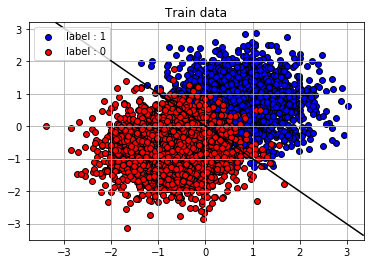

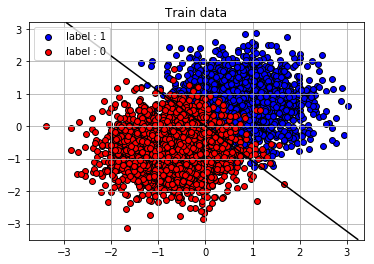

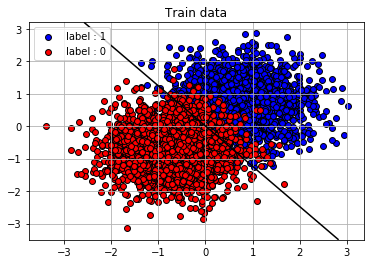

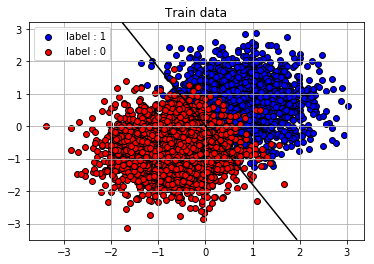

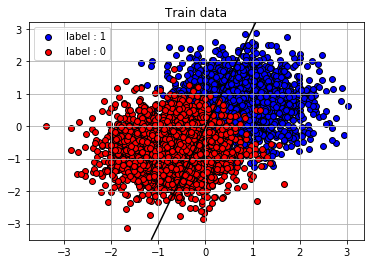

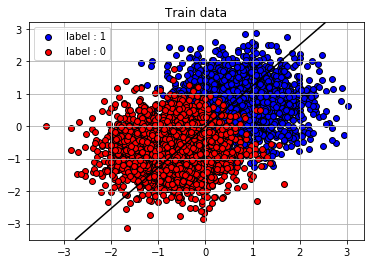

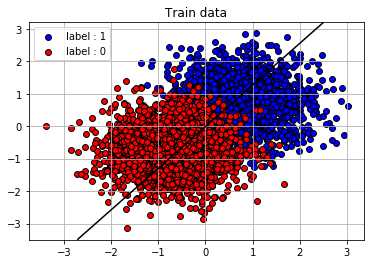

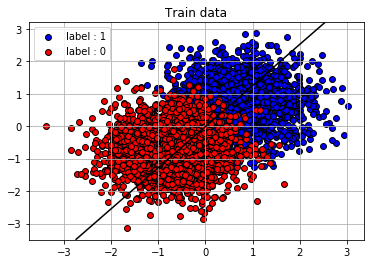

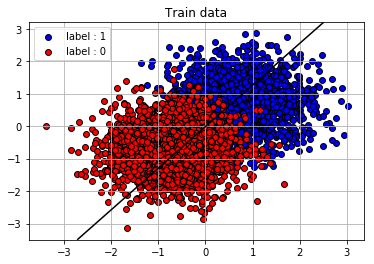

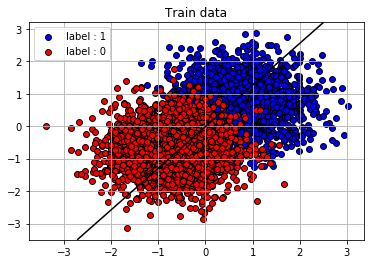

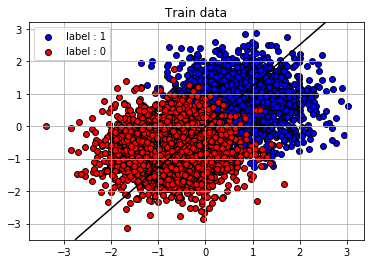

In [22]:
for d in model_history:
    w, b = d["w"], d["b"]
    
    draw_boundary(w, b, X_train, Y_train)
    plt.show()

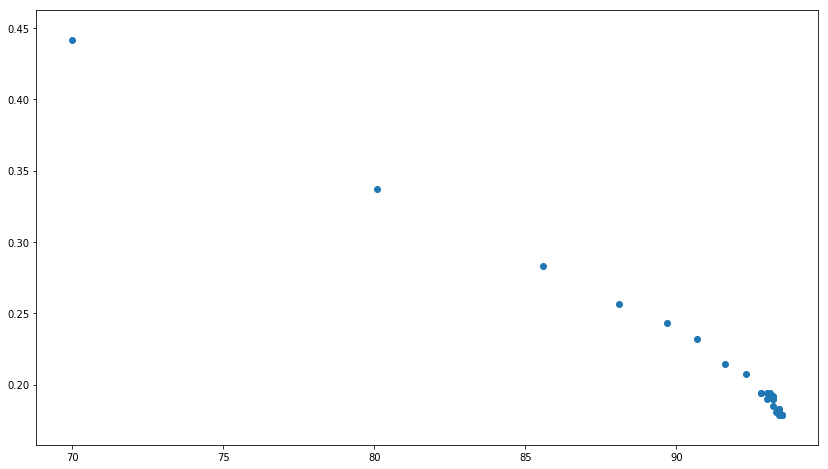

In [41]:
acc_fairness_np = np.array(acc_fairness)
plt.figure(figsize=(14,8))
plt.scatter(acc_fairness_np[:-1, 1], acc_fairness_np[:-1, 2])
plt.show()

In [42]:
acc_fairness

[(0.0, 93.5, 0.17857142857142858),
 (0.035, 93.4, 0.18080357142857142),
 (0.07, 93.4, 0.18080357142857142),
 (0.10500000000000001, 93.4, 0.18080357142857142),
 (0.14, 93.4, 0.18080357142857142),
 (0.17500000000000002, 93.4, 0.18080357142857142),
 (0.21000000000000002, 93.5, 0.17857142857142858),
 (0.24500000000000002, 93.5, 0.17857142857142858),
 (0.28, 93.4, 0.17857142857142858),
 (0.31500000000000006, 93.3, 0.18080357142857142),
 (0.35000000000000003, 93.4, 0.18303571428571427),
 (0.385, 93.4, 0.18303571428571427),
 (0.42000000000000004, 93.2, 0.18526785714285715),
 (0.45500000000000007, 93.2, 0.18973214285714285),
 (0.49000000000000005, 93.2, 0.18973214285714285),
 (0.525, 93.0, 0.18973214285714285),
 (0.56, 93.1, 0.19419642857142858),
 (0.5950000000000001, 93.0, 0.19419642857142858),
 (0.6300000000000001, 93.2, 0.19196428571428573),
 (0.665, 93.1, 0.19196428571428573),
 (0.7000000000000001, 92.8, 0.19419642857142858),
 (0.7350000000000001, 92.8, 0.19419642857142858),
 (0.77, 92.3, 

In [ ]:
def plot(data, labels, title='Train data', s=35, axis=False, xlim=None, ylim=None):
    plt.scatter(data.T[labels==1][:, 0], data.T[labels==1][:, 1], color='b', edgecolor='k', label='label : 1', s=s)
    plt.scatter(data.T[labels==0][:, 0], data.T[labels==0][:, 1], color='r', edgecolor='k', label='label : 0', s=s)
    plt.grid(True)
    plt.title(title)
    plt.legend()
    if axis:
        plt.axvline(x=0, color='black', linewidth=1)
        plt.axhline(y=0, color='black', linewidth=1)
    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)

def decision_boundary(w, b, xlim, ylim, colormap):
    xmin, xmax = xlim
    ymin, ymax = ylim
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 30), np.linspace(ymin, ymax, 30))
    grids = np.c_[xx.ravel(), yy.ravel()]
    predict = forward(w, b, grids.T)
    Z = predict.reshape(xx.shape)
    plt.contour(xx, yy, Z, levels=[0.5], colors='k')
    if colormap == True:
        plt.contourf(xx, yy, Z, cmap='RdBu', alpha=0.7)

def draw_boundary(w, b, data, labels, title='Train data', colormap=False, s=35, axis=False, xlim=None, ylim=None):
    # 먼저 데이터 플롯한다
    plot(data, labels, title=title, s=s, axis=axis, xlim=xlim, ylim=ylim)
    axes = plt.gca() # 현재 플롯된 axes객체를 가져온다
    xlim = axes.get_xlim()
    ylim = axes.get_ylim()
    # 학습모델의 Decision boundary
    decision_boundary(w, b, xlim, ylim, colormap)